# Data Wrangling
In this notebook we'll obtain all of our data, arrange it how we want, and store it in the proper directories.

In [1]:
%run setup.ipynb
data_dir = Path('../data')
output_dir = Path('../output')

## Retrieve Tide Gauge Data

We are interested in getting tide gauge and alitmetry data for the Hawaiian Islands (and surrounds) for 1993 through 2022.
Let's first establish where the tide gauges are by looking at the tide gauge dataset. We'll retrieve tide gauge data from the UHSLC (University of Hawaii Sea Level Center) fast-delivery dataset {cite:t}``. The fast-delivery data are released within 1-2 months of data collection and are subject only to basic quality control. 

We'll be retrieving the hourly data for our station group at from UHSLC, and saving this to our data directory so we don't have to download again.

In [2]:
# hawaii stations are: 
stationdict = {
    'Hilo': '060',
    'Kawaihae': '552',
    'Kahului': '059',
    'Mokuoloe': '061',
    'Honolulu': '057',
    'Nawiliwili': '058',
    'Johnston Island': '052',
    'Midway Island': '050',
    'Kaumalapau': '548',
    'Barbers Point': '547',
    'French Frigate Shoals': '014',
}
stationdict.values()

station_group = 'Hawaii'

````{margin}
```{note}
What about research quality data (RQD)? 
RQD undergo thorough and time-consuming QC, and are usually released 1-2 years after data is received. 
```
````

In [3]:
url = "https://uhslc.soest.hawaii.edu/data/netcdf/fast/hourly/" 
uhslc_ids = list(stationdict.values())

for uhslc_id in uhslc_ids:
    fname = f'h{uhslc_id}.nc' # h for hourly, d for daily

    path = os.path.join(data_dir, 'tide_gauge_nc',fname)

    if not os.path.exists(path):
        urlretrieve(os.path.join(url, fname), path) 
        print(f'Downloading {fname} from {url} to {path}')

Now we merge all the datasets. This can take a while.

In [4]:
data_dir

PosixPath('../data')

In [5]:
# Load the data

import glob        
# Get a list of all .nc files in the data directory
files = glob.glob(os.path.join(data_dir,'tide_gauge_nc','h*.nc'))

# Open the datasets
datasets = [xr.open_dataset(file) for file in files]

#merge in batches of 2 to avoid memory issues
batch_size = 2
merged_datasets = []

for i in range(0, len(datasets), batch_size):
    batch = datasets[i:i+batch_size]
    merged_batch = xr.merge(batch)
    merged_datasets.append(merged_batch)

#merge the merged datasets
rsl = xr.merge(merged_datasets)

# convert byte strings to normal strings
rsl['station_name'] = rsl['station_name'].astype(str)
rsl['station_country'] = rsl['station_country'].astype(str)
rsl['ssc_id'] = rsl['ssc_id'].astype(str)

rsl

<xarray.Dataset> Size: 54MB
Dimensions:               (time: 1043870, record_id: 11)
Coordinates:
  * time                  (time) datetime64[ns] 8MB 1905-01-01T10:00:00.02880...
  * record_id             (record_id) int16 22B 140 500 520 ... 5470 5480 5520
Data variables:
    sea_level             (record_id, time) float32 46MB nan nan nan ... nan nan
    lat                   (record_id) float32 44B 23.87 28.22 ... 20.78 20.03
    lon                   (record_id) float32 44B 193.7 182.6 ... 203.0 204.2
    station_name          (record_id) <U17 748B 'French Frigate' ... 'Kawaihae'
    station_country       (record_id) <U30 1kB 'United States of America (the...
    station_country_code  (record_id) float32 44B 840.0 840.0 ... 840.0 840.0
    uhslc_id              (record_id) float32 44B 14.0 50.0 52.0 ... 548.0 552.0
    gloss_id              (record_id) float32 44B 107.0 106.0 109.0 ... nan nan
    ssc_id                (record_id) <U4 176B 'fren' 'midx' ... 'kaum' 'kawa'
    last_rq_date          (record_id) datetime64[ns] 88B 2018-10-03T22:59:59....
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2024-03-07T14:27:49Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [6]:
def get_MHHW_uhslc_datums(id, datumname): 
    
    url = 'https://uhslc.soest.hawaii.edu/stations/TIDES_DATUMS/fd/LST/fd'+f'{int(id):03}'+'/datumTable_'+f'{int(id):03}'+'_m.html'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table')
    table = table.find_all('tr')[1:] # skip header row
    table = '<table>' + ''.join([str(x) for x in table]) # add back the table tag
    table_io = io.StringIO(str(table))
    datumtable = pd.read_html(table_io)[0]
    datum = datumtable[datumtable['Datum'] == datumname]['Value'].values[0]
    # ensure datum is a float
    datum = float(datum)
    return datum

In [7]:
# add MHHW to the dataset
rsl['MHHW'] = xr.DataArray([1000*get_MHHW_uhslc_datums(id, 'MHHW') for id in rsl['uhslc_id'].values], dims='record_id', coords={'record_id': rsl['record_id']})

rsl['MHHW'].attrs['units'] = 'mm'
rsl['MHHW'].attrs['long_name'] = 'Mean Higher High Water, rel. to station datum'

In [8]:
#save rsl to the data directory
rsl.to_netcdf(data_dir / 'rsl_hawaii.nc')

## Retrieve altimetry data 
We are using the global ocean gridded L4 [Sea Surface Heights and Derived Variables](https://doi.org/10.48670/moi-00148) from Copernicus. 

To download a subset of the global altimetry data, run get_CMEMS_data.py from this directory in a terminal with python >= 3.9 + copernicus_marine_client installed OR uncomment out the call to get_CMEMS_data and run it in this notebook. To read more about how to download the data from the Copernicus Marine Toolbox (new as of December 2023), visit https://help.marine.copernicus.eu/en/articles/7949409-copernicus-marine-toolbox-introduction. 

````{margin}
```{note}
You will need a username and password to access the CMEMS (Copernicus Marine Service) data if this is the first time running the client. To register for data access (free), visit https://data.marine.copernicus.eu/register.  
```
````

```{admonition} Large data download!
:class: warning
Getting errors on the code block below? Remember to uncomment "get_CMEMS_data()" to download. Note that if you change nothing in the function, it will download ~600 MB of data, which may take a long time!! You will only need to do this once. The dataset will be stored in the data directory you specify (which should be the same data directory we defined above).
```

In [9]:
# get the min and max lat and lon of rsl for altimetry data retrieval
minlat = float(rsl.lat.min().values)
maxlat = float(rsl.lat.max().values)
minlon = float(rsl.lon.min().values)
maxlon = float(rsl.lon.max().values)

In [10]:
def get_CMEMS_data(minlat, maxlat, minlon, maxlon, data_dir=data_dir):
        
    #maxlat = 15
    #minlat = 0
    #minlon = 125
    #maxlon = 140
    maxlat = maxlat+2
    minlat = minlat-2
    maxlon = maxlon+2
    minlon  = minlon-2
    
    start_date_str = "1993-01-01T00:00:00"
    end_date_str = "2023-04-30T23:59:59"
    data_dir = data_dir
    
    """
    Retrieves Copernicus Marine data for a specified region and time period.
    
    Args:
        minlon (float): Minimum longitude of the region.
        maxlon (float): Maximum longitude of the region.
        minlat (float): Minimum latitude of the region.
        maxlat (float): Maximum latitude of the region.
        start_date_str (str): Start date of the data in ISO 8601 format.
        end_date_str (str): End date of the data in ISO 8601 format.
        data_dir (str): Directory to save the retrieved data.
    
    Returns:
        str: The filename of the retrieved data.
    """
    copernicusmarine.subset(
        dataset_id="cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D",
        dataset_version="202112",
        variables=["sla"],
        minimum_longitude=minlon,
        maximum_longitude=maxlon,
        minimum_latitude=minlat,
        maximum_latitude=maxlat,
        start_datetime=start_date_str,
        end_datetime=end_date_str,
        output_directory=data_dir,
        output_filename="cmems_L4_SSH_0.25deg_" + start_date_str[0:4] + "_" + end_date_str[0:4] + ".nc"
    )
fname_cmems = 'cmems_L4_SSH_0.25deg_1993_2023.nc'

In [11]:

# check if the file exists, if not, download it
if not os.path.exists(data_dir / fname_cmems):
    print('You will need to download the CMEMS data in a separate script')
    get_CMEMS_data(minlat, maxlat, minlon, maxlon, data_dir) #<<--- COMMENT OUT TO AVOID ACCIDENTAL DATA DOWNLOADS.
else:
    print('CMEMS data already downloaded, good to go!')

CMEMS data already downloaded, good to go!


Open up the CMEMS data and take a look. We will want to make an ASL dataset similar in structure to the RSL data so that we can easily compare the two.

In [12]:
# open the CMEMS data
ds = xr.open_dataset(data_dir / fname_cmems)

ds

<xarray.Dataset> Size: 577MB
Dimensions:    (time: 11077, latitude: 62, longitude: 105)
Coordinates:
  * latitude   (latitude) float32 248B 14.88 15.12 15.38 ... 29.62 29.88 30.12
  * longitude  (longitude) float32 420B -179.1 -178.9 -178.6 ... -153.4 -153.1
  * time       (time) datetime64[ns] 89kB 1993-01-01 1993-01-02 ... 2023-04-30
Data variables:
    sla        (time, latitude, longitude) float64 577MB ...
Attributes: (12/45)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...
    copernicusmarine_version:        1.0.5

In [13]:
# Extract data for the nearest point to the tide gauge location that has data
sla = []
for lat, lon in zip(rsl['lat'].values, rsl['lon'].values):
    sla.append(ds['sla'].sel(
        longitude=lon-360, latitude=lat, method='nearest'
    ))

    #if the data is null, nan average over the nearest 4 points
    tol = 0.25
    if sla[-1].isnull().all():
        sla[-1] = ds['sla'].sel(
            longitude=slice(lon-360-tol, lon-360+tol), 
            latitude=slice(lat-tol, lat+tol)
        ).mean(dim=['latitude', 'longitude'])
        sla[-1]['latitude'] = np.mean(lat)
        sla[-1]['longitude'] = np.mean(lon)

sla = xr.concat(sla, dim='record_id')




# make sla a dataset with variables from rsl
sla = sla.to_dataset(name='sla')
sla['station_name'] = rsl['station_name']

# Creating lat_str and lon_str arrays with 'record_id' as their dimension
lat_str = [f'{np.abs(lat):.3f}\u00B0{"N" if lat > 0 else "S"}' for lat in sla.latitude.values]
lon_str = [f'{np.abs(lon):.3f}\u00B0{"E" if lon > 0 else "W"}' for lon in sla.longitude.values]  

# Convert lists to DataArrays with 'record_id' as their dimension
lat_str_da = xr.DataArray(lat_str, dims=['record_id'], coords={'record_id': rsl['record_id']})
lon_str_da = xr.DataArray(lon_str, dims=['record_id'], coords={'record_id': rsl['record_id']})

# Assign these DataArrays to the sla dataset
sla['lat_str'] = lat_str_da
sla['lon_str'] = lon_str_da

# add original data source to attributes
sla.attrs['original_data_source'] = 'CMEMS L4 SSH 0.25deg'
sla.attrs['title'] = ds.attrs['title']
sla.attrs['source_file'] = str(data_dir / fname_cmems)

# ensure latitude and longitude are coordinates associated with a location
sla = sla.set_coords(['latitude', 'longitude'])



sla

<xarray.Dataset> Size: 1MB
Dimensions:       (record_id: 11, time: 11077)
Coordinates:
    latitude      (record_id) float32 44B 23.88 28.12 16.88 ... 20.88 20.12
    longitude     (record_id) float32 44B -166.4 -177.4 -169.6 ... -156.9 -155.9
  * time          (time) datetime64[ns] 89kB 1993-01-01 ... 2023-04-30
  * record_id     (record_id) int16 22B 140 500 520 570 ... 610 5470 5480 5520
Data variables:
    sla           (record_id, time) float64 975kB -0.037 -0.0404 ... -0.0293
    station_name  (record_id) <U17 748B 'French Frigate' 'Midway' ... 'Kawaihae'
    lat_str       (record_id) <U8 352B '23.875°N' '28.125°N' ... '20.125°N'
    lon_str       (record_id) <U9 396B '166.375°W' '177.375°W' ... '155.875°W'
Attributes:
    original_data_source:  CMEMS L4 SSH 0.25deg
    title:                 DT merged all satellites Global Ocean Gridded SSAL...
    source_file:           ../data/cmems_L4_SSH_0.25deg_1993_2023.nc

In [14]:
#save sla to the data directory
sla.to_netcdf(data_dir / 'asl_hawaii.nc')

## Processing
### Process the tide gauge data to match CMEMS
 Now we'll convert tide gauge data into a daily record for the POR in units of meters to match the CMEMS data. 
 
 The next code block:
 - extracts tide gauge data for the period 1993-2022
 - converts it to meters
 - removes any NaN values
 - resamples the data to daily mean
 - and normalizes it relative to the 1993-2012 epoch. 
 

The resulting data is stored in the variable 'rsl_daily' with units in meters.

In [15]:
# Next, let's establish a period of record from 1993-2022.
# establish the time period of interest
start_date = dt.datetime(1993,1,1)
end_date = dt.datetime(2022,12,31)
#
# also save them as strings, for plotting
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

In [16]:
# Extract the data for the period of record (POR)
tide_gauge_data_POR = rsl['sea_level'].sel(time=slice(start_date, end_date))

# Convert to meters and drop any NaN values
tide_gauge_data_meters = tide_gauge_data_POR / 1000  # Convert from mm to meters
# tide_gauge_data_clean = tide_gauge_data_meters.dropna(dim='time')

# Resample the tide gauge data to daily mean before subtracting the epoch mean
tide_gauge_daily_avg = tide_gauge_data_meters.resample(time='1D').mean()


In [17]:
tide_gauge_daily_avg

<xarray.DataArray 'sea_level' (record_id: 11, time: 10957)> Size: 482kB
array([[       nan,        nan,        nan, ..., 0.96316665, 0.91866666,
        0.835     ],
       [0.99616665, 1.0284166 , 1.0202917 , ..., 1.3059167 , 1.2347916 ,
        1.262     ],
       [0.8844583 , 0.88150007, 0.85529166, ..., 1.0427917 , 1.0572916 ,
        1.064     ],
       ...,
       [       nan,        nan,        nan, ..., 3.4656668 , 3.440625  ,
        3.35      ],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ..., 1.0995833 , 1.0876666 ,
        0.96      ]], dtype=float32)
Coordinates:
  * record_id  (record_id) int16 22B 140 500 520 570 580 ... 610 5470 5480 5520
  * time       (time) datetime64[ns] 88kB 1993-01-01 1993-01-02 ... 2022-12-31

### Normalize the tide gauge data relative to the 1993-2012 epoch

In [18]:

epoch_start, epoch_end = start_date, '2011-12-31'
epoch_daily_avg = tide_gauge_daily_avg.sel(time=slice(epoch_start, epoch_end))
epoch_daily_mean = epoch_daily_avg.mean(dim='time')

In [19]:
# Subtract the epoch daily mean from the tide gauge daily average
rsl_daily = tide_gauge_daily_avg - epoch_daily_mean

# Set the attributes of the rsl_daily data
rsl_daily.attrs = tide_gauge_data_POR.attrs
rsl_daily.attrs['units'] = 'm'

# add lat and lon to the dataset
rsl_daily['lat'] = rsl['lat']
rsl_daily['lon'] = rsl['lon']

# add the station name and country
rsl_daily['station_name'] = rsl['station_name']

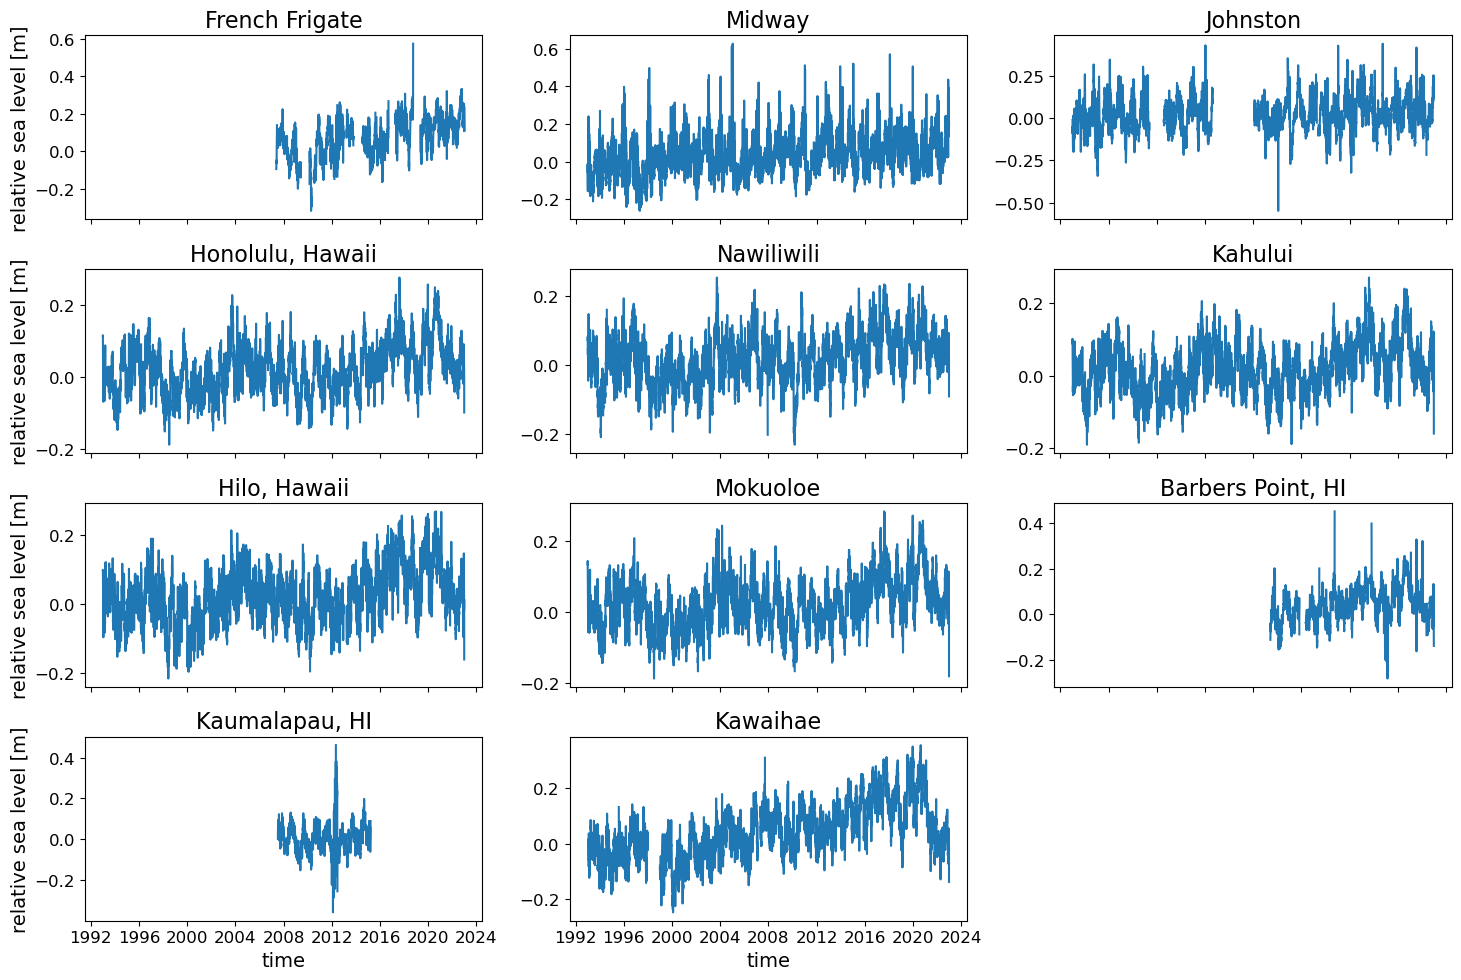

In [20]:
g = rsl_daily.plot(x='time', col='record_id', col_wrap=3, sharey=False, sharex=True, figsize=(15, 10))

# Use g.axs to iterate over the axes in the FacetGrid
for ax, rid in zip(g.axs.flat, rsl_daily.record_id):
    # Accessing the station_name coordinate for the current record_id directly
    station_name = rsl_daily.station_name.sel(record_id=rid).item()
    ax.set_title(station_name)

plt.show()


In [21]:
# Subtract the epoch daily mean from the tide gauge daily average
rsl_daily_mhhw = tide_gauge_daily_avg - rsl['MHHW']/1000

# Set the attributes of the rsl_daily data
rsl_daily_mhhw.attrs = tide_gauge_data_POR.attrs
rsl_daily_mhhw.attrs['long_name'] = 'water level above MHHW'
rsl_daily_mhhw.attrs['units'] = 'm'
# add lat and lon to the dataset
rsl_daily_mhhw['lat'] = rsl['lat']
rsl_daily_mhhw['lon'] = rsl['lon']
# add the station name and country
rsl_daily_mhhw['station_name'] = rsl['station_name']

rsl_daily_mhhw.name = 'sea_level (mhhw)'
# save rsl_daily to the data directory
# rsl_daily_mhhw.to_netcdf(data_dir / 'rsl_daily_hawaii_mhhw.nc')


#combine the two datasets
rsl_daily_combined = xr.merge([rsl_daily, rsl_daily_mhhw])

# save rsl_daily_combined to the data directory
rsl_daily_combined.to_netcdf(data_dir / 'rsl_daily_hawaii.nc')

## Retrieve Climate Indices

In [22]:
# Download ENSO/ Oceanic Niño Index (ONI)

url = 'https://psl.noaa.gov/data/correlation/oni.data'

# parse the data into a timeseries
oni = pd.read_csv(url, sep= '\s+', skiprows=1, header=None, names=['Year', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])

# take only first 74 rows
oni = oni.head(74)

# Convert the 'Year' column to integer type
oni['Year'] = oni['Year'].astype(int)

# melt the dataframe to long format
oni = oni.melt(id_vars='Year', var_name='Month', value_name='ONI')

# Create a datetime column from the 'Year' and 'Month' columns, where month is the middle of the month
oni['Month'] = oni['Month'].astype(int)
oni['Day'] = 15
oni['Date'] = pd.to_datetime(oni[['Year', 'Month', 'Day']])

# Set the 'Date' column as the index
oni = oni.set_index('Date')

# Drop the 'Year', 'Month', and 'Day' columns
oni = oni.drop(columns=['Year', 'Month', 'Day'])

# make sure ONI is a float
oni['ONI'] = oni['ONI'].astype(float)


# sort the index by date
oni = oni.sort_index()

# First classify the ONI values as El Niño, La Niña, or Neutral
oni['ONI_event'] = oni['ONI'].apply(lambda x: 1 if x >= 0.5 else (-1 if x <= -0.5 else 0))


#for all ONI_events, sum the ONI_event for the next 5 months. If the sum is 5, it is an El Niño event, if it is -5, it is a La Niña event
oni['ONI_event_duration_start'] = oni['ONI_event'].rolling(5).sum().shift(-4)

# Note this method will leave NaNs at the end of the series, but that's okay, because we are only interested in the start of the event
 
# find the start of the event, defined as the first month with -5 in ONI_event_duration_start
oni['La Nina'] = oni['ONI_event_duration_start'].apply(lambda x: 1 if x == -5 else 0)
# get positive zero crossings
oni['La Nina'] = oni['La Nina'].where(oni['La Nina'] == 1).ffill(limit=4)

#do the same for El Nino
oni['El Nino'] = oni['ONI_event_duration_start'].apply(lambda x: 1 if x == 5 else 0)
# get positive zero crossings
oni['El Nino'] = oni['El Nino'].where(oni['El Nino'] == 1).ffill(limit=4)

#change the NaNs to 0 and turn Nino and Nina into boolean
oni['El Nino'] = oni['El Nino'].fillna(0).astype(bool)
oni['La Nina'] = oni['La Nina'].fillna(0).astype(bool)

#remove the intermediate columns
oni = oni.drop(columns=['ONI_event', 'ONI_event_duration_start'])

oni


,ONI,La Nina,El Nino
Date,,,
1950-01-15,-1.53,False,False
1950-02-15,-0.68,False,False
1950-03-15,-0.43,False,False
1950-04-15,-0.15,False,False
1950-05-15,0.16,False,False
...,...,...,...
2023-08-15,1.32,False,True
2023-09-15,1.56,False,True
2023-10-15,1.78,False,True


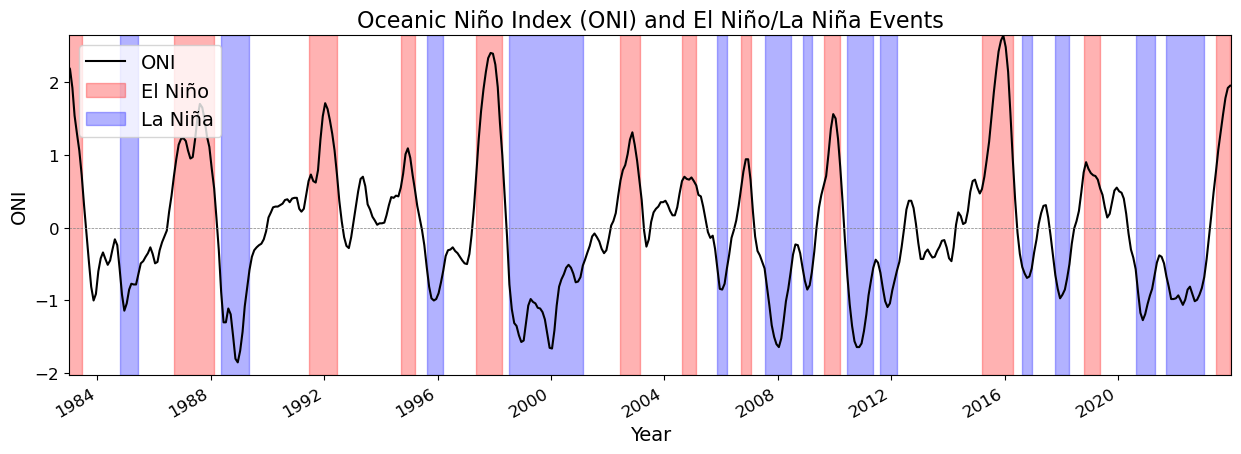

In [23]:
# plot it to see if we got it right
fig, ax = plt.subplots(figsize=(15, 5))

# Plotting the ONI timeseries
oni['ONI'].plot(ax=ax, color='black', label='ONI', legend=True)

# Shading El Niño events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['El Nino'] == 1, color='red', alpha=0.3, label='El Niño')

# Shading La Niña events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['La Nina'] == 1, color='blue', alpha=0.3, label='La Niña')

# Adding labels and title
ax.set_xlabel('Year')
ax.set_ylabel('ONI')
ax.set_title('Oceanic Niño Index (ONI) and El Niño/La Niña Events')

# Formatting the date axis to only show the year
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

# Adding horizontal line at ONI = 0 for reference
ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')

# Adding a legend
ax.legend(loc='upper left')

# set xlim to 1983 to 2023
ax.set_xlim(pd.Timestamp('1983-01-01'), pd.Timestamp('2023-12-31'))
ax.set_ylim(oni['ONI'].min(), oni['ONI'].max())

# Show the plot
plt.show()



In [24]:
# save to the data directory
oni.to_csv(data_dir / 'oni.csv')